# First Graded Assignment 
## (Aaron - Architecture 1)

## Setup

### Init modules and helper functions
Load modules and set seed

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2.4.1


Helper function to plot history

In [2]:
#helper functions for visualisation

# same function as in the getting started notebook, 
# but now plotting the loss functions used in this notebook
# we plot the loss we want to optimise on th eleft (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

### Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

#!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading and visualizing the data

In [4]:
# load train and test data
(x_train_all, r_train_all_class), (x_test, r_test_class) = mnist.load_data()
x_train_all = x_train_all.reshape(x_train_all.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
x_train_all = x_train_all.astype('float32')
x_test = x_test.astype('float32')
x_train_all /= 255
x_test /= 255

print(x_train_all.shape[0], ' original train samples')
print(x_test.shape[0], ' original test samples')

# This data set contains a train set and test set
# we still need to split off a validation set

# Number of test samples
N_test = x_test.shape[0]

# split off 10000 samples for validation
N_val = 10000
N_train = x_train_all.shape[0] - N_val

# now extract the samples into train, validate and test sets
# set random state to make sure you get the same split each time
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size = N_val, random_state=0)

# For initial explorations, it is often useful to 
# try out some things first on a smaller data set
# in comment below is the code for using all training data
# in this case, we select 10000 samples for training
# don't forget to use all training examples for your final model
# by replacing the line below by the commented one beneath it

# CHANGE!

#N_train = 10000

x_train = x_train[:N_train,:]
r_train_class = r_train_class[:N_train]

print("Using ",x_train.shape[0]," train samples, ", x_val.shape[0], " validation samples and ",x_test.shape[0]," test samples")
print("Each sample has ",x_train.shape[1]," features")

60000  original train samples
10000  original test samples
Using  50000  train samples,  10000  validation samples and  10000  test samples
Each sample has  784  features


A few labels:
[7 6 4 2 5 9 1 8 8]


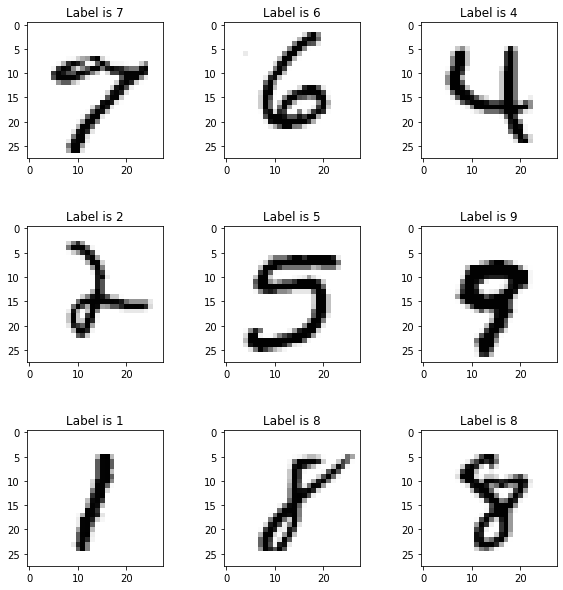

In [5]:
# The features in this data set are the pixels of a 28x28 pixel image
# You can visualise an individual image as follows
# (here for the first 9 images in the training set)

f = plt.figure(figsize=(10,10));
for idx in range(9):
    plt.subplot(3,3,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label is " + str(r_train_class[idx]))
    plt.imshow(np.reshape(x_train[idx,:],(28,28)), cmap='Greys', interpolation='None')

# The labels are numbers from 0 to 9
print("A few labels:")
print(r_train_class[:9])

### Convert labels for multiclass

In [6]:
r_train_all = keras.utils.to_categorical(r_train_all_class)
r_train = keras.utils.to_categorical(r_train_class)
r_val = keras.utils.to_categorical(r_val_class)
r_test = keras.utils.to_categorical(r_test_class)

# look at the new labels

## Model Architecture

In [18]:
num_classes = 10

# this first network has 2 hidden layers
# the first layer needs to be told explicitly what the input shape is
# the output layer has 10 neurons: one neuron per class

# Note that we use the "He" initialisation scheme here, since this is often advised 
# for layers with ReLu neurons - although you are free to change this, it is not necessary for this assignment

# Also note that "dropout" is implemented in separate layers in Keras
# they are added below in comment to show you how to use them
# note that you can also start your network with a dropout layer (randomly setting input features to 0)

def initial_model():
    # create linear model
    model = Sequential()
    # we start with a first fully connected layer
    model.add(Dense(392, activation='relu', input_shape=(784,), kernel_initializer='he_uniform'))
    ## then add some dropout, set at a very low value for now
    model.add(Dropout(0.5))
    # a second dense layer with half as many neurons
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    ## some more dropout
    #model.add(Dropout(0.001))
    # and the output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001), # set to default learning rate here
                  metrics=['accuracy']) # save accuracy in addition to cross entropy error
    return model

## Training

In [19]:
# Model checkpoints are saved versions of intermediate models during training

# Set the path for saving intermediate model checkpoints

# With the setting below, models will be dumped in your drive in the specified folder (make this folder first)
# Change this path name to a unique path for each model you want to keep (otherwise they will be overwritten)

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/Architecture1/"
print("Models will be saved in ",checkpoint_dir)
# Have a look what is already in that path
!ls "{checkpoint_dir}"


# CHANGE THIS!
# architecture1_model_version_0.1
model_savename = checkpoint_dir+"architecture1_model_version_0.5.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"


# Create your model
model_1 = initial_model()
model_1.summary()


# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 32
epochs = 30

# Modelcheckpoint callback:
# - save at every epoch if 'save_best_only'=false
# - save complete model if 'save weights only' = false

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Set early stopping: with parameters below, training will stop 
# when validation accuracy hasn't improved for 6 epochs
# (or when the total number of epochs has passed)
# If necessary, you can also set a threshold, ignoring all improvements below the threshold
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4,min_delta=0.0001)

# NOTE that it may be useful NOT to use early stopping while you are tisll tuning learning convergence
# also be sure to adapt the patience in order to allow convergence

# Putting verbose = 1 below (instead of 0 i the previous notebook) plots out 1 line per epoch
history_1 = model_1.fit(x_train, r_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [cp_callback, stopping_callback],
                    validation_data=(x_val, r_val)
                    )
# If you want to save the weights of this trained model, run:
model_1.save_weights(model_savename)

Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/Architecture1/
architecture1_model_version_0.1.h5  cp-0008.ckpt.index
architecture1_model_version_0.2.h5  cp-0009.ckpt.data-00000-of-00001
architecture1_model_version_0.3.h5  cp-0009.ckpt.index
architecture1_model_version_0.4.h5  cp-0010.ckpt.data-00000-of-00001
checkpoint			    cp-0010.ckpt.index
cp-0001.ckpt.data-00000-of-00001    cp-0011.ckpt.data-00000-of-00001
cp-0001.ckpt.index		    cp-0011.ckpt.index
cp-0002.ckpt.data-00000-of-00001    cp-0012.ckpt.data-00000-of-00001
cp-0002.ckpt.index		    cp-0012.ckpt.index
cp-0003.ckpt.data-00000-of-00001    cp-0013.ckpt.data-00000-of-00001
cp-0003.ckpt.index		    cp-0013.ckpt.index
cp-0004.ckpt.data-00000-of-00001    cp-0014.ckpt.data-00000-of-00001
cp-0004.ckpt.index		    cp-0014.ckpt.index
cp-0005.ckpt.data-00000-of-00001    cp-0015.ckpt.data-00000-of-00001
cp-0005.ckpt.index		    cp-0015.ckpt.index
cp-0006.ckpt.data-00000-of-00001    cp-0016.ckpt.data-00000-of-0

## Analyse
Analyse the trained model on train data and validation data

### Analyse last model

Training set Accuracy: 0.9980
Training set Loss:0.011395

Validation set Accuracy: 0.9827
Validation set Loss:0.059354



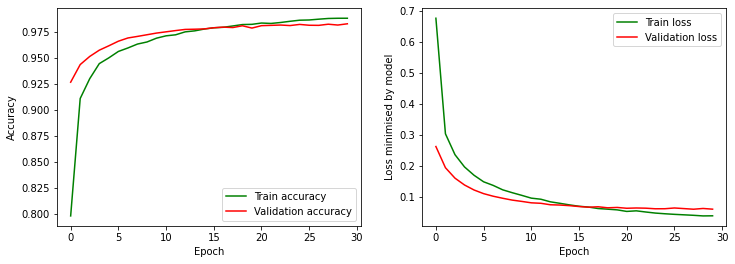

In [20]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

### Analyse best model (from checkpoint)

In [21]:
import pathlib

# Find latest checkpoint
# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
print(latest)

# Now restore the model

best_model_1 = initial_model() # this is a new model
best_model_1.load_weights(latest)

# The code below should give slightly better results than that for the original model
[train_loss, train_accuracy] = best_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = best_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/Architecture1/cp-0030.ckpt
Training set Accuracy: 0.9980
Training set Loss:0.011395

Validation set Accuracy: 0.9827
Validation set Loss:0.059354



## Final model and analysis
All train data, basic measurements on testdata

### Retrain on all data

In [22]:
model_for_test = initial_model()
model_1.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 32
epochs = 30

history_for_test = model_for_test.fit(x_train_all, r_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 392)               307720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                25152     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 333,522
Trainable params: 333,522
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 1.0531 - accuracy: 0.6759
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3051 - accuracy: 0.9104
Epoch 3/30
1875/1875 [====================

### Plot Accuracy and Loss

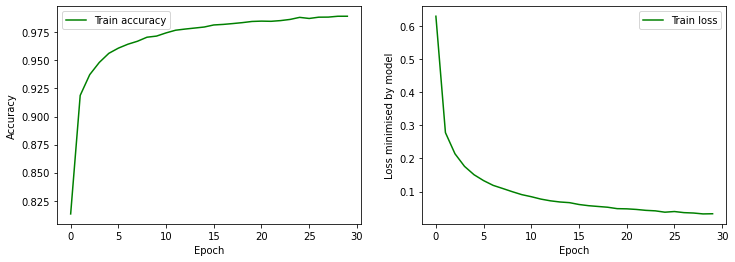

In [23]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

### Saving the whole model

In [24]:
#the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
modelpath = checkpoint_dir+"architecture1_final_model.h5"

print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
model_for_test.save(modelpath)

Final model saved as  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/Architecture1/architecture1_final_model.h5


### Measurements on final model

In [25]:
# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = model_for_test.evaluate(x_train_all, r_train_all, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[test_loss, test_accuracy] = model_for_test.evaluate(x_test, r_test, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(test_accuracy))
print("Validation set Loss:{:7.6f}\n".format(test_loss))

Training set Accuracy: 0.9978
Training set Loss:0.010046

Validation set Accuracy: 0.9841
Validation set Loss:0.059360

